In [17]:
# -*- coding: UTF-8 -*-
# Python3

from sklearn import tree
import numpy as np

import os
import json

# DATASET: GTZAN genre collection

Audios disponibles en:
    The dataset consists of 1000 audio tracks each 30 seconds long.
    It contains 10 genres, each represented by 100 tracks.
    The tracks are all 22050Hz Mono 16-bit audio files in .wav format.

    http://marsyas.info/downloads/datasets.html

Ground truth, géneros: blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, roc
(100 archivos por género)

Procesado con Essentia (http://essentia.upf.edu/documentation/)

    Valores promedio (mean) de los siguientes descriptores
    [ 
                'lowlevel.spectral_centroid',
                'lowlevel.dissonance',
                'lowlevel.mfcc',
                'lowlevel.mfcc_bands',
                'sfx.inharmonicity', 
                'rhythm.bpm
    ]
    En el .json se agrega el género y un id único     

Descriptores MIR para cada audio (.au) almacenados en archivos .json (uno por cada audio)

#### Nota: No se entrena con todos, se excluyen los que luego se van a utilizar para predecir.




### Ejemplo json

In [18]:
cat dataset/descriptores/blues.00001.json

{"lowlevel.dissonance.mean": "0.435817778111", "lowlevel.mfcc_bands.mean": "0.00309278", "sfx.inharmonicity.mean": "0.072731718421", "rhythm.bpm.mean": "67.7719039917", "lowlevel.spectral_centroid.mean": "2191.51098633", "lowlevel.mfcc.mean": "-695.122", "genre": "blues", "id": "blues.00001"}

In [19]:
files_dir = 'dataset/descriptores'

In [45]:
descriptors = [
                'lowlevel.dissonance.mean',
                'lowlevel.mfcc_bands.mean',
                'sfx.inharmonicity.mean',
                'rhythm.bpm.mean',    
                'lowlevel.spectral_centroid.mean',    
                'lowlevel.mfcc.mean',
                ]

In [44]:
#ls dataset/descriptores # list json files

In [21]:
#TODO: autonumerate
codify_genre = { 
    'blues': 0,
    'classical': 1,
    'country': 2,
    'disco': 3,
    'hiphop': 4,
    'jazz': 5,
    'metal': 6,
    'pop': 7,
    'reggae': 8,
    'rock': 9
}
undecode_genre = {v: k for k, v in codify_genre.items()}

def load_song_from_json(json_filename):
    data = json.load( open(json_filename,'r') )
    song_id = data.pop('id')
    song_genre = codify_genre[ str(data.pop('genre')) ]
    x = np.array( [float(v) for (k,v) in data.items()], dtype=float)
    return song_id, undecode_genre[song_genre], x

len_vector = 6 #amount of data value of descriptors
arr = np.empty((0,len_vector), float)
target_arr = np.empty((0,1), float)

for subdir, dirs, files in os.walk(files_dir):
    for f in files:
        if os.path.splitext(f)[1]==".json":
            data = json.load( open(files_dir + "/" + f,'r') )
            song_id = data.pop('id')
            song_genre = codify_genre[ str(data.pop('genre')) ]
            target_arr = np.append(target_arr, song_genre)
            x = np.array( [float(v) for (k,v) in data.items()], dtype=float)
            arr = np.vstack((arr, x))

## Entrenamiento

In [22]:
ct = tree.DecisionTreeClassifier()
ct_entrenado = ct.fit( arr, target_arr ) #cargo los datos (entreno)

def genre_predict(ct_entrenado, x_arr):
    return undecode_genre[ ct_entrenado.predict( x_arr.reshape(1,-1) )[0] ]

### Pruebas de predicción

In [23]:
test_id, test_genre, test_arr = load_song_from_json( 'dataset/pruebas/pop.00010.json' )
test_genre, test_arr

('pop', array([  4.43471521e-01,   9.70065000e-03,   7.65194297e-02,
          1.06967133e+02,   2.11458838e+03,  -5.79939000e+02]))

In [24]:
print( "Género predecido: ", genre_predict(ct_entrenado, test_arr.reshape(1,-1)) )

Género predecido:  country


In [25]:
test_id, test_genre, test_arr = load_song_from_json( 'dataset/pruebas/country.00031.json' )
test_genre, test_arr

('country', array([  4.47215110e-01,   1.63228000e-03,   6.21108934e-02,
          1.10562599e+02,   2.25280249e+03,  -5.99665000e+02]))

In [26]:
print( "Género predecido: ", genre_predict(ct_entrenado, test_arr.reshape(1,-1)) )

Género predecido:  disco


In [27]:
# al agregar al entrenamiento con el género country, falla (sin ese, clasifica OK)
# al agregar hiphop vuelve a clasificar bien
test_id, test_genre, test_arr = load_song_from_json( 'dataset/pruebas/blues.00005.json' )
test_genre, test_arr

('blues', array([  4.13481325e-01,   5.61112000e-05,   5.49932234e-02,
          6.83032532e+01,   2.24271191e+03,  -6.62832000e+02]))

In [28]:
print( "Género predecido: ", genre_predict(ct_entrenado, test_arr.reshape(1,-1)) )

Género predecido:  country


In [29]:
# esta canción blues clasifica OK
test_id, test_genre, test_arr = load_song_from_json( 'dataset/pruebas/blues.00021.json' )
test_genre, test_arr

('blues', array([  4.01932120e-01,   1.25262000e-03,   5.18891178e-02,
          1.00242500e+02,   2.34314429e+03,  -7.47678000e+02]))

In [30]:
print( "Género predecido: ", genre_predict(ct_entrenado, test_arr.reshape(1,-1)) )

Género predecido:  blues


In [31]:
test_id, test_genre, test_arr = load_song_from_json( 'dataset/pruebas/reggae.00052.json' )
test_genre, test_arr

('reggae', array([  4.72415090e-01,   2.26356000e-02,   2.88092017e-01,
          9.96622391e+01,   2.15012451e+03,  -5.70954000e+02]))

In [32]:
print( "Género predecido: ", genre_predict(ct_entrenado, test_arr.reshape(1,-1)) )

Género predecido:  pop


In [33]:
test_id, test_genre, test_arr = load_song_from_json( 'dataset/pruebas/metal.00023.json' )
test_genre, test_arr

('metal', array([  4.86335456e-01,   1.36190000e-02,   1.09521285e-01,
          1.45000031e+02,   2.03619116e+03,  -5.16890000e+02]))

In [34]:
print( "Género predecido: ", genre_predict(ct_entrenado, test_arr.reshape(1,-1)) )

Género predecido:  metal


## Algunas conclusiones

Entrenando con pocos géneros posibles clasificó bien los ejemplos tomados. Al entrenar con blues, classical y pop por ejemplo. Cuando a eso se le sumo el género country. Clasficó al tema 0005 de blues como de aquel género (country). Al agregar el entrenamiento hiphop, lo volvió a clasificar bien. Al agregar jazz, confunde pop.00010.json con blues...

En principio pareciera que confunde country con blues y/o pop. Lo cuál es razonable a nivel armonias (al escuchar).

Aunque son los que se observó en bibliografía que son los que se suelen utilizar, puede ser que los descriptores calculados no sean adecuados. Salvo en el BPM, tal vez sea necesario entrenar con todo el vector de valores, en lugar del valor promedio que puede no ser representativo de la canción.

Nota: los ejemplos con los que no fue entrenado el clasificador y se utilizaron para predecir, fueron tomados del mismo dataset de archivos de audio.

In [55]:
# from http://scikit-learn.org/stable/modules/tree.html
import graphviz

genres = list({k for k, v in codify_genre.items()})

dot_data = tree.export_graphviz(ct, out_file=None, 
                         feature_names=descriptors,  
                         class_names=genres,  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("Géneros")
#graph # displays here

'Géneros.pdf'

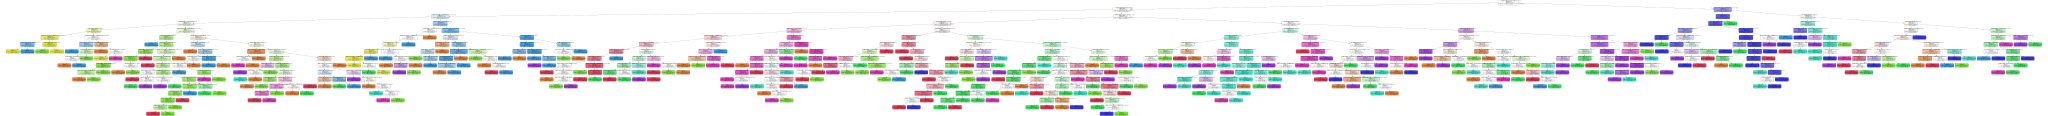

In [54]:
graph